In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q swig
!pip install -q gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 42.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 89.2 MB/s eta 0:00:00


In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random 
from collections import namedtuple, deque 
import gymnasium as gym

In [ ]:
env = gym.make("CarRacing-v2",continuous=False)

In [ ]:
env.observation_space

Box(0, 255, (96, 96, 3), uint8)

In [ ]:
env.action_space

Discrete(5)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork,self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=4, stride=2) # 3 * 96 * 96
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2) # 32 * 47 * 47
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=2) # 64 * 22 * 22
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=2) # 128 * 10 * 10
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1) # 256 * 6 * 6
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, stride=1) # 256 * 6 * 6

        self.fc1= nn.Linear(256 * 1 * 1, 100) 
        self.fc2 = nn.Linear(100,100)
        self.fc3 = nn.Linear(100,5)
        self.float()

    def forward(self, x):
        x = torch.permute(x, (0, 3, 1, 2))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = x.reshape(-1, 256 * 1 * 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)    

In [ ]:
class Agent():
    def __init__(self):
        self.qnetwork_local = QNetwork().to(device)
        self.qnetwork_target = QNetwork().to(device)
        self.memory = deque(maxlen=10000) 
        self.gamma = 0.97    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9999
        self.batch_size = 512
        self.train_start = 3000
        
        self.counter_1 = 0
        self.counter_2 = 0

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr=0.001)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        sample = random.random()
        if sample > self.epsilon:
            action = np.argmax(action_values.cpu().data.numpy())
            return action
        else:
            action =  random.choice(np.arange(5))
            return action

    def step(self, state, action, reward, next_state, done):
        self.remember(state, action, reward, next_state, done)
        self.counter_2 = (self.counter_2+1) % 500
        self.counter_1 = (self.counter_1+1) % 4

        if self.counter_2 == 0:
            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

        if self.counter_1 == 0 and len(self.memory) >= self.train_start:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            minibatch = random.sample(self.memory, min(len(self.memory), self.batch_size))
            self.learn(minibatch)
    
    def learn(self, batch):

        criterion = torch.nn.MSELoss()

        states =  np.zeros((self.batch_size, 96, 96 ,3))
        next_states =  np.zeros((self.batch_size, 96, 96 ,3))
        actions, rewards, dones = [], [], []

        for i in range(self.batch_size):
            state_i, action_i, reward_i, next_state_i, done_i = batch[i]
            states[i] = state_i
            next_states[i] = next_state_i  
            actions.append(action_i)
            rewards.append(reward_i)
            dones.append(done_i)
        

        actions = np.vstack(actions).astype(np.int)
        actions = torch.from_numpy(actions).to(device)

        rewards = np.vstack(rewards).astype(np.float)
        rewards = torch.from_numpy(rewards).to(device)

        dones = np.vstack(dones).astype(np.int)
        dones = torch.from_numpy(dones).to(device)



        self.qnetwork_local.train()
        self.qnetwork_target.eval()

        predictions = self.qnetwork_local(torch.from_numpy(states).float().to(device)).gather(1,actions)

        with torch.no_grad():
            q_next = self.qnetwork_target(torch.from_numpy(next_states).float().to(device)).detach().max(1)[0].unsqueeze(1)
        
        targets = rewards + (self.gamma * q_next * (1-dones))
        targets = targets.float()
        loss = criterion(predictions,targets).to(device)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()




In [ ]:
agent = Agent()
rewards = [] 
total_episodes = 1500
max_steps = 1000

for episode in range(total_episodes):
    state, _ = env.reset()
    cumulative_reward = 0 
    
    for i in range(max_steps):
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        agent.step(state,action,reward,next_state,done)
        state = next_state
        cumulative_reward += reward
        if done:
            break
    
    rewards.append(cumulative_reward)
    print(f"Episode {episode}/{total_episodes}, Return = {cumulative_reward}, The epsilon now is : {agent.epsilon}")

Episode 0/1500, Return = -49.64028776978498, The epsilon now is : 1.0
Episode 1/1500, Return = -54.71698113207625, The epsilon now is : 1.0


<ipython-input-13-5ae87425a46e>:68: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  actions = np.vstack(actions).astype(np.int)
<ipython-input-13-5ae87425a46e>:71: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rewards = np.v

Episode 2/1500, Return = -54.69255663430503, The epsilon now is : 0.9999
Episode 3/1500, Return = -59.45945945946033, The epsilon now is : 0.9752111619411448
Episode 4/1500, Return = -58.1881533101053, The epsilon now is : 0.9511319235669539
Episode 5/1500, Return = -50.57034220532397, The epsilon now is : 0.9276472330643509
Episode 6/1500, Return = -46.93877551020477, The epsilon now is : 0.9047424102692004
Episode 7/1500, Return = -49.82078853046672, The epsilon now is : 0.8824031374898074
Episode 8/1500, Return = -54.22535211267692, The epsilon now is : 0.8606154505570021
Episode 9/1500, Return = -40.00000000000043, The epsilon now is : 0.8393657300952052
Episode 10/1500, Return = -39.50177935943135, The epsilon now is : 0.8186406930090225
Episode 11/1500, Return = -34.42622950819699, The epsilon now is : 0.7984273841800505
Episode 12/1500, Return = -29.765886287625584, The epsilon now is : 0.7787131683686925
Episode 13/1500, Return = -28.571428571428658, The epsilon now is : 0.7594

KeyboardInterrupt: ignored

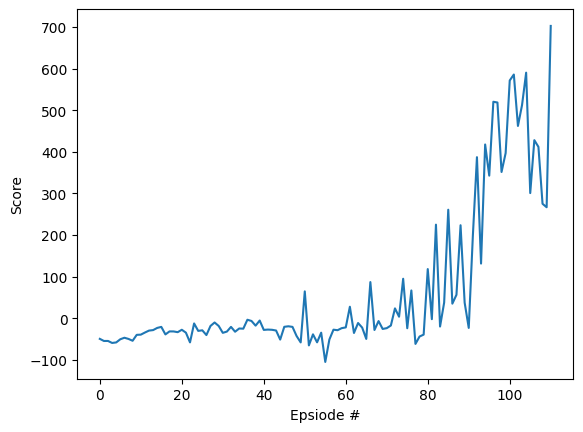

In [ ]:
import matplotlib.pylab as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(rewards)),rewards)
plt.ylabel('Score')
plt.xlabel('Epsiode #')
plt.show()

torch.save(agent.qnetwork_target.state_dict(), '/content/drive/MyDrive/ColabNotebooks/CarRacing/weights.pt')

In [ ]:
best_reward = 700

for episode in range(500):
    state, _ = env.reset()
    cumulative_reward = 0 
    
    for i in range(max_steps):
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        agent.step(state,action,reward,next_state,done)
        state = next_state
        cumulative_reward += reward
        if done:
            break

        if cumulative_reward >= best_reward:
            best_reward = cumulative_reward
            torch.save(agent.qnetwork_target.state_dict(), '/content/drive/MyDrive/ColabNotebooks/CarRacing/weights_best.pt')
    
    rewards.append(cumulative_reward)
    print(f"Episode {episode}/{total_episodes}, Return = {cumulative_reward}, The epsilon now is : {agent.epsilon}")

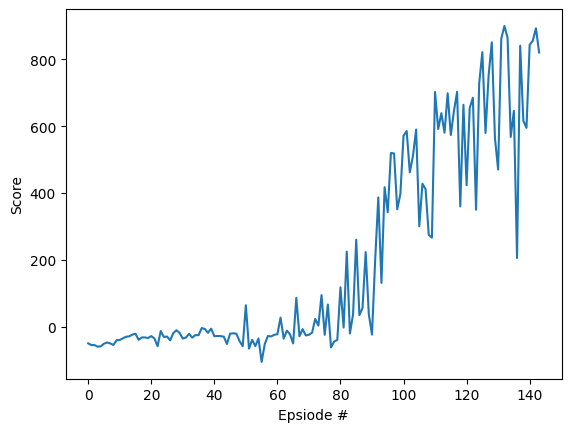

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(rewards)),rewards)
plt.ylabel('Score')
plt.xlabel('Epsiode #')
plt.show()

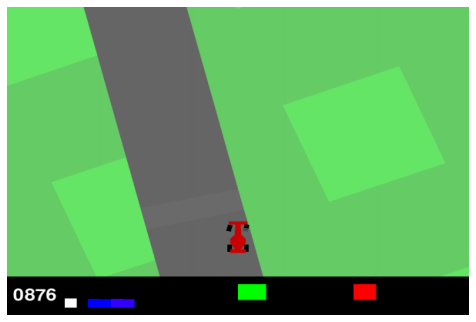

In [ ]:
from matplotlib import animation

agent.qnetwork_target.load_state_dict(torch.load('/content/drive/MyDrive/ColabNotebooks/CarRacing/weights_best.pt'))

def save_frames_as_gif(frames, path='/content/drive/MyDrive/ColabNotebooks/CarRacing', filename='gym_animation_3.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

env2 = gym.make("CarRacing-v2",continuous=False, render_mode="rgb_array")

observation, _ = env2.reset()
frames = []
for t in range(1000):
    #Render to frames buffer
    frames.append(env2.render())
    action = agent.act(observation)
    observation, _, done, _, _ = env2.step(action)
    if done:
        break
env.close()
save_frames_as_gif(frames)